In [3]:
# --- Common setup for figs 6–9 (run once) ---
from pathlib import Path
import sys, json, math
import numpy as np
import matplotlib.pyplot as plt

# Make repo importable and load config
REPO = Path.cwd().parent
sys.path.insert(0, str(REPO))
from src import config as C

DER   = C.DERIV_DIR
FIGS  = C.FIG_DIR
FIGS.mkdir(parents=True, exist_ok=True)

# Minimal modern style
plt.rcParams.update({
    "figure.figsize": (10, 4.2),
    "figure.dpi": 140,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.titleweight": "bold",
    "axes.labelweight": "regular",
    "font.size": 11,
})

# Load continuous HG envelope (time x channels) aligned to video time
env_npz = np.load(DER / "continuous_hg_env.npz")
ENV = env_npz["env"]                 # (samples, n_good_channels), float32
FS  = float(env_npz["fs"][0])        # 1200.0
offset_samples = int(env_npz["offset_samples"][0])
channels_used  = env_npz["channels_used"]

# Load meta (optional)
meta_path = (DER / "continuous_hg_env.json")
if meta_path.exists():
    meta = json.load(open(meta_path, "r"))
    print("Loaded meta:", meta)
else:
    meta = {}

# Load video diode (~30 Hz) as proxy for visual events/brightness
video_diode = np.load(DER / "video_diode.npy")
FPS = len(video_diode) / C.DURATION_S

# Helpers
def zscore(x, axis=None, eps=1e-12):
    m = np.mean(x, axis=axis, keepdims=True)
    s = np.std(x, axis=axis, keepdims=True)
    return (x - m) / (s + eps)

def resample_poly_rs(x, fs_in, fs_out):
    """Resample 1D array x from fs_in to fs_out with rational polyphase."""
    from scipy.signal import resample_poly
    from math import gcd
    up = int(round(fs_out * 1000))
    dn = int(round(fs_in * 1000))
    g  = math.gcd(up, dn)
    return resample_poly(x, up//g, dn//g)

def detect_edges_hysteresis(x, fs, low_q=1, high_q=99, arm=0.6, disarm=0.2, min_isi_ms=20.0):
    """Rising-edge detector robust to analog/binary waveforms."""
    x = np.asarray(x, float)
    lo, hi = np.percentile(x, [low_q, high_q])
    if hi <= lo: hi = lo + 1.0
    xn = np.clip((x - lo) / (hi - lo), 0, 1)
    armed, last = True, -10**9
    min_isi = int(round(min_isi_ms/1000.0 * fs))
    edges = []
    for i in range(1, len(xn)):
        if armed and xn[i-1] < arm <= xn[i]:
            if i - last >= min_isi:
                edges.append(i)
                last = i
                armed = False
        elif not armed and xn[i] < disarm:
            armed = True
    return np.asarray(edges, int)

print(f"ENV shape: {ENV.shape}, FS: {FS}, FPS(video): {FPS:.3f}, offset_samples: {offset_samples}, channels_used: {len(channels_used)}")


Loaded meta: {'fs': 1200.0, 'hg_band': [110.0, 140.0], 'smooth_ms': 25.0, 'alignment_offset_samples': -425, 'channels_used_0b': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 152, 153, 154, 155, 157, 158, 159], 'input_file': 'C:\\Users\\aryan\\iCloudDrive\\gtec hackathon\\ecog-video\\data\\derivatives\\filtered_data.npy'}
ENV shape: (322049, 156), FS: 1200.0, FPS(video): 30.048, offset_samples: -425, channe

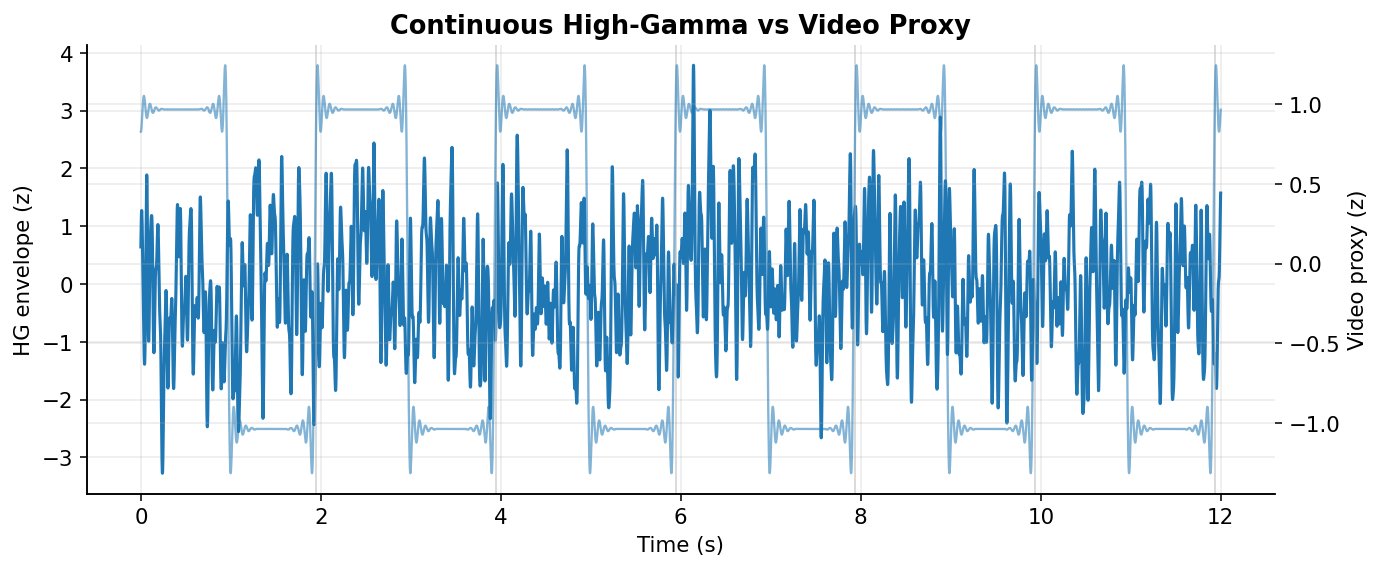

Saved: C:\Users\aryan\iCloudDrive\gtec hackathon\ecog-video\reports\figures\fe_06_continuous_hg_overlay.png


In [7]:
# === Figure 6: Continuous HG envelope vs video proxy (save: fe_06_continuous_hg_overlay.png) ===
seconds = 12.0
start_s = 30.0   # adjust to a visually interesting segment (in seconds)
start = int(start_s * FS)
N     = int(seconds * FS)

# Mean HG envelope across channels (z-scored across time for visibility)
env_mean = ENV[:, :].mean(axis=1).astype(float)

# bounds check so we don't slice past the end
end = min(len(env_mean), int(start + N))
env_seg  = env_mean[start:end]
env_seg_z = np.asarray(zscore(env_seg)).ravel()  # <-- was zscore(env_seg)[:, 0]

# Resample video_diode to 1200 Hz and take matching segment
video_up = resample_poly_rs(video_diode, FPS, FS)
vid_seg  = video_up[start:end]
vid_seg_z = np.asarray(zscore(vid_seg)).ravel()  # <-- was zscore(vid_seg)[:, 0]


# Detect rising edges in the ORIGINAL 30 Hz signal, then map to 1200 Hz indices for markers
edges_30 = detect_edges_hysteresis(video_diode, fs=FPS, min_isi_ms=25.0)
edges_1200 = (edges_30 * (FS / FPS)).astype(int)
edge_mask = (edges_1200 >= start) & (edges_1200 < start+N)
edges_in_seg = edges_1200[edge_mask] - start

t = np.arange(N) / FS

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(t, env_seg_z, linewidth=1.6)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("HG envelope (z)")
ax1.set_title("Continuous High-Gamma vs Video Proxy")

ax2.plot(t, vid_seg_z, alpha=0.55, linewidth=1.2)
ax2.set_ylabel("Video proxy (z)")

# Event markers
for e in edges_in_seg[::max(1, len(edges_in_seg)//30)]:  # draw some, not all, to avoid clutter
    ax1.axvline(e/FS, color='0.75', linewidth=0.8, alpha=0.7)

fig.tight_layout()
out = C.FIG_DIR / "fe_06_continuous_hg_overlay.png"
fig.savefig(out, dpi=160)
plt.show()
print("Saved:", out)


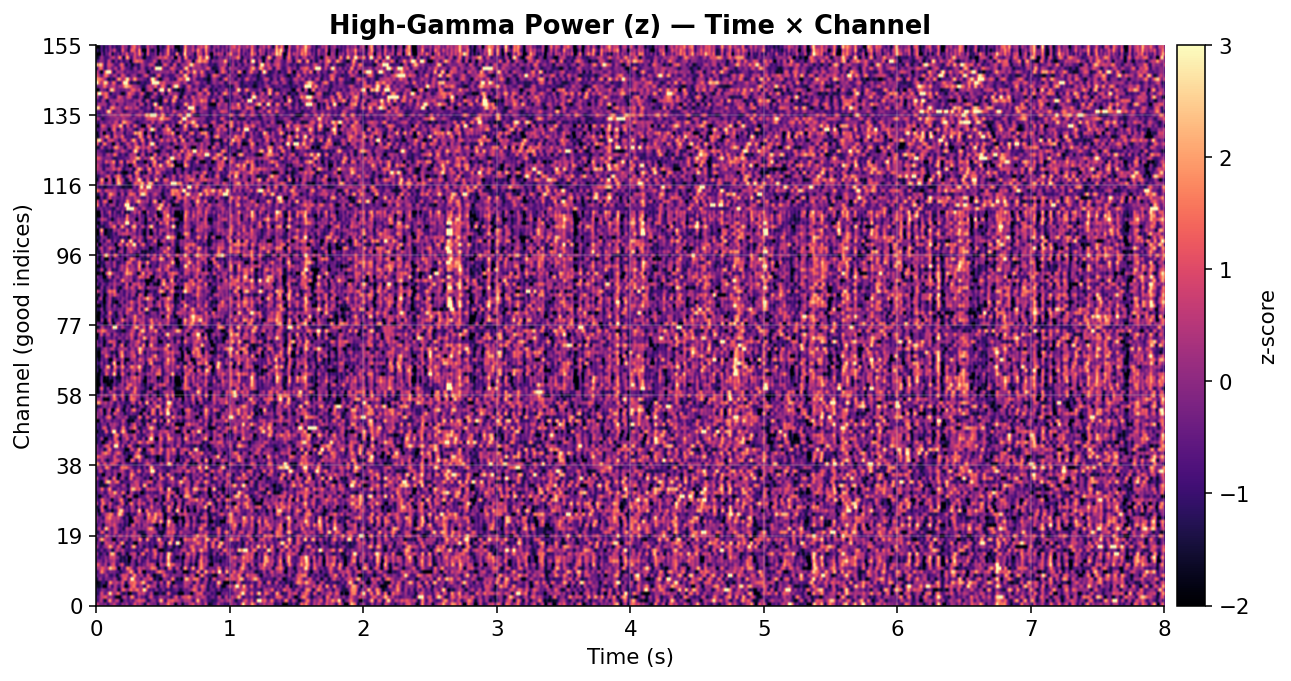

Saved: C:\Users\aryan\iCloudDrive\gtec hackathon\ecog-video\reports\figures\fe_07_hg_heatmap.png


In [3]:
# === Figure 7: HG heatmap (time × channel) (save: fe_07_hg_heatmap.png) ===
seconds = 8.0
start_s = 60.0   # pick a different stretch than fig 6 to avoid repetition
start = int(start_s * FS)
N     = int(seconds * FS)

seg = ENV[start:start+N, :]          # (time, channels)
seg_z = zscore(seg, axis=0)          # z across time per channel

fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(
    seg_z.T, aspect="auto", origin="lower",
    extent=[0, seconds, 0, seg_z.shape[1]],
    cmap="magma", vmin=-2, vmax=3
)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Channel (good indices)")
ax.set_title("High-Gamma Power (z) — Time × Channel")
cb = fig.colorbar(im, ax=ax, pad=0.01)
cb.set_label("z-score")

# Optional subtle channel ticks
ax.set_yticks(np.linspace(0, seg_z.shape[1], 9))
ax.set_yticklabels([f"{int(x)}" for x in np.linspace(0, seg_z.shape[1]-1, 9)])

fig.tight_layout()
out = C.FIG_DIR / "fe_07_hg_heatmap.png"
fig.savefig(out, dpi=180)
plt.show()
print("Saved:", out)



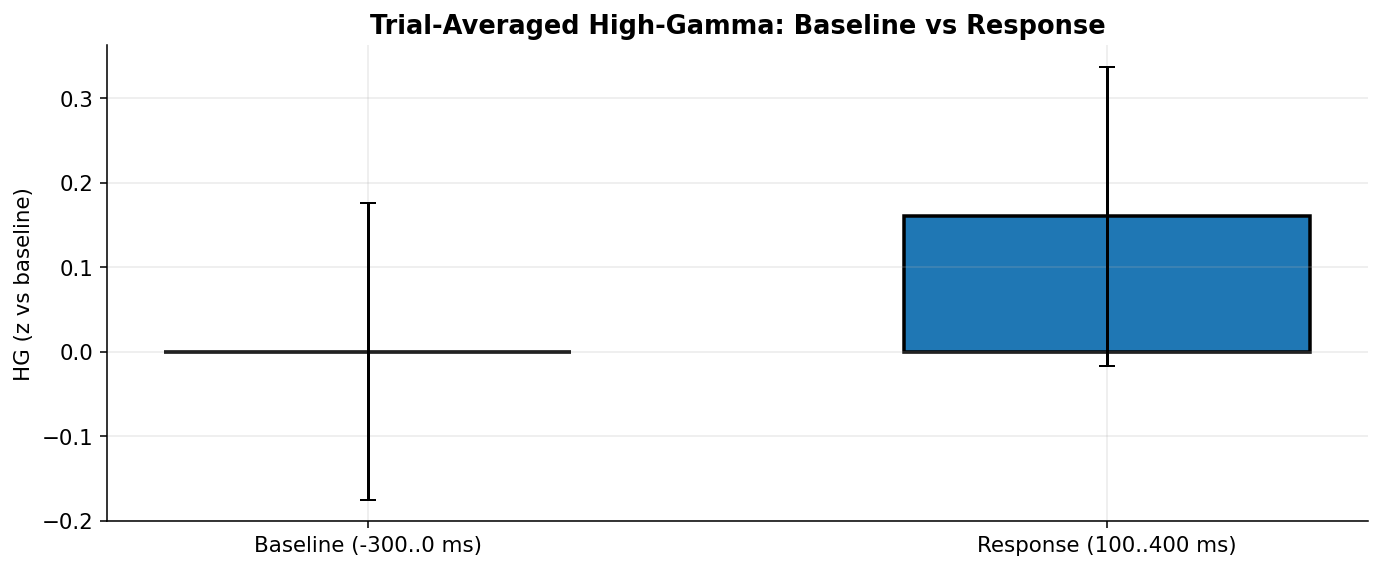

Trials used: 126  |  Saved: C:\Users\aryan\iCloudDrive\gtec hackathon\ecog-video\reports\figures\fe_08_baseline_response.png


In [5]:
# === Figure 8: Baseline vs Response (save: fe_08_baseline_response.png) ===
BL_ms = C.BASELINE_MS
RS_ms = C.RESPONSE_MS

# Convert ms windows to samples
def ms_to_samp(ms): return int(round(ms/1000.0 * FS))
BL = (ms_to_samp(BL_ms[0]), ms_to_samp(BL_ms[1]))  # negative .. 0
RS = (ms_to_samp(RS_ms[0]), ms_to_samp(RS_ms[1]))

# Trial starts from video_diode rising edges (in 1200 Hz sample space)
edges_30 = detect_edges_hysteresis(video_diode, fs=FPS, min_isi_ms=25.0)
edges_1200 = (edges_30 * (FS / FPS)).astype(int)

# For each trial, collect mean HG (across channels) in baseline and response windows
bl_vals, rs_vals = [], []
env_mean_ch = ENV.mean(axis=1)  # mean across channels for global effect
for s0 in edges_1200:
    bl_a = s0 + BL[0]
    bl_b = s0 + BL[1]
    rs_a = s0 + RS[0]
    rs_b = s0 + RS[1]
    if bl_a < 0 or rs_b >= len(env_mean_ch): 
        continue
    bl_vals.append(env_mean_ch[bl_a:bl_b].mean())
    rs_vals.append(env_mean_ch[rs_a:rs_b].mean())

bl_vals = np.array(bl_vals, float)
rs_vals = np.array(rs_vals, float)

# Convert to z relative to baseline distribution for comparability
bl_mu, bl_sd = bl_vals.mean(), bl_vals.std() + 1e-12
bl_z = (bl_vals - bl_mu) / bl_sd
rs_z = (rs_vals - bl_mu) / bl_sd

def ci95(a):
    m = a.mean()
    se = a.std(ddof=1) / max(1, np.sqrt(len(a)))
    return m, 1.96*se

m_bl, e_bl = ci95(bl_z)
m_rs, e_rs = ci95(rs_z)

fig, ax = plt.subplots()
x = np.array([0, 1])
m = np.array([m_bl, m_rs])
e = np.array([e_bl, e_rs])

ax.bar(x, m, yerr=e, capsize=4, width=0.55)
#ax.errorbar(x, m, yerr=e, fmt='o', capsize=6, color='black', markersize=8, linewidth=1.5)
ax.bar(x, m, yerr=e, capsize=4, width=0.55, color='none', edgecolor='black', linewidth=1.8)

ax.set_xticks(x, ["Baseline (-300..0 ms)", "Response (100..400 ms)"])
ax.set_ylabel("HG (z vs baseline)")
ax.set_title("Trial-Averaged High-Gamma: Baseline vs Response")
fig.tight_layout()
out = C.FIG_DIR / "fe_08_baseline_response.png"
fig.savefig(out, dpi=160)
plt.show()
print(f"Trials used: {len(bl_z)}  |  Saved:", out)


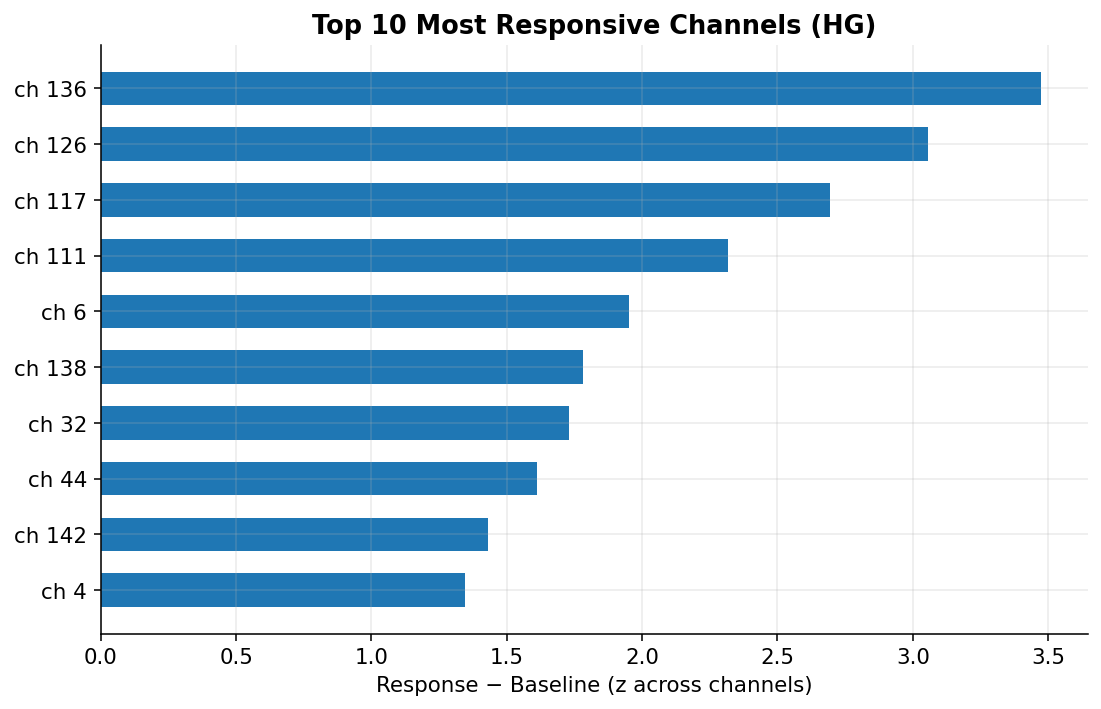

Saved: C:\Users\aryan\iCloudDrive\gtec hackathon\ecog-video\reports\figures\fe_09_top10_channels.png


In [6]:
# === Figure 9: Top 10 responsive channels (save: fe_09_top10_channels.png) ===
BL_ms = C.BASELINE_MS
RS_ms = C.RESPONSE_MS
BL = (ms_to_samp(BL_ms[0]), ms_to_samp(BL_ms[1]))
RS = (ms_to_samp(RS_ms[0]), ms_to_samp(RS_ms[1]))

edges_30 = detect_edges_hysteresis(video_diode, fs=FPS, min_isi_ms=25.0)
edges_1200 = (edges_30 * (FS / FPS)).astype(int)

# Compute per-channel baseline & response across trials → mean delta per channel
nC = ENV.shape[1]
deltas = np.zeros(nC, float)
counts = np.zeros(nC, int)

for s0 in edges_1200:
    bl_a, bl_b = s0 + BL[0], s0 + BL[1]
    rs_a, rs_b = s0 + RS[0], s0 + RS[1]
    if bl_a < 0 or rs_b >= len(ENV): 
        continue
    bl = ENV[bl_a:bl_b, :].mean(axis=0)   # (channels,)
    rs = ENV[rs_a:rs_b, :].mean(axis=0)
    delta = rs - bl
    deltas += delta
    counts += 1

mask = counts > 0
deltas = deltas[mask] / counts[mask]

# z-score across channels so scale is comparable for display
deltas_z = np.asarray(zscore(deltas)).ravel()
chan_idx = np.arange(nC)[mask]

# Get top 10
topk = 10 if len(deltas_z) >= 10 else len(deltas_z)
order = np.argsort(deltas_z)[-topk:]
top_vals = deltas_z[order]
top_ch   = chan_idx[order]

# Plot (horizontal bar, ascending)
asc = np.argsort(top_vals)
top_vals = top_vals[asc]
top_ch   = top_ch[asc]

fig, ax = plt.subplots(figsize=(8, 5.2))
ax.barh(range(topk), top_vals, height=0.6)
ax.set_yticks(range(topk), [f"ch {c}" for c in top_ch])
ax.set_xlabel("Response − Baseline (z across channels)")
ax.set_title("Top 10 Most Responsive Channels (HG)")
fig.tight_layout()
out = C.FIG_DIR / "fe_09_top10_channels.png"
fig.savefig(out, dpi=180)
plt.show()
print("Saved:", out)


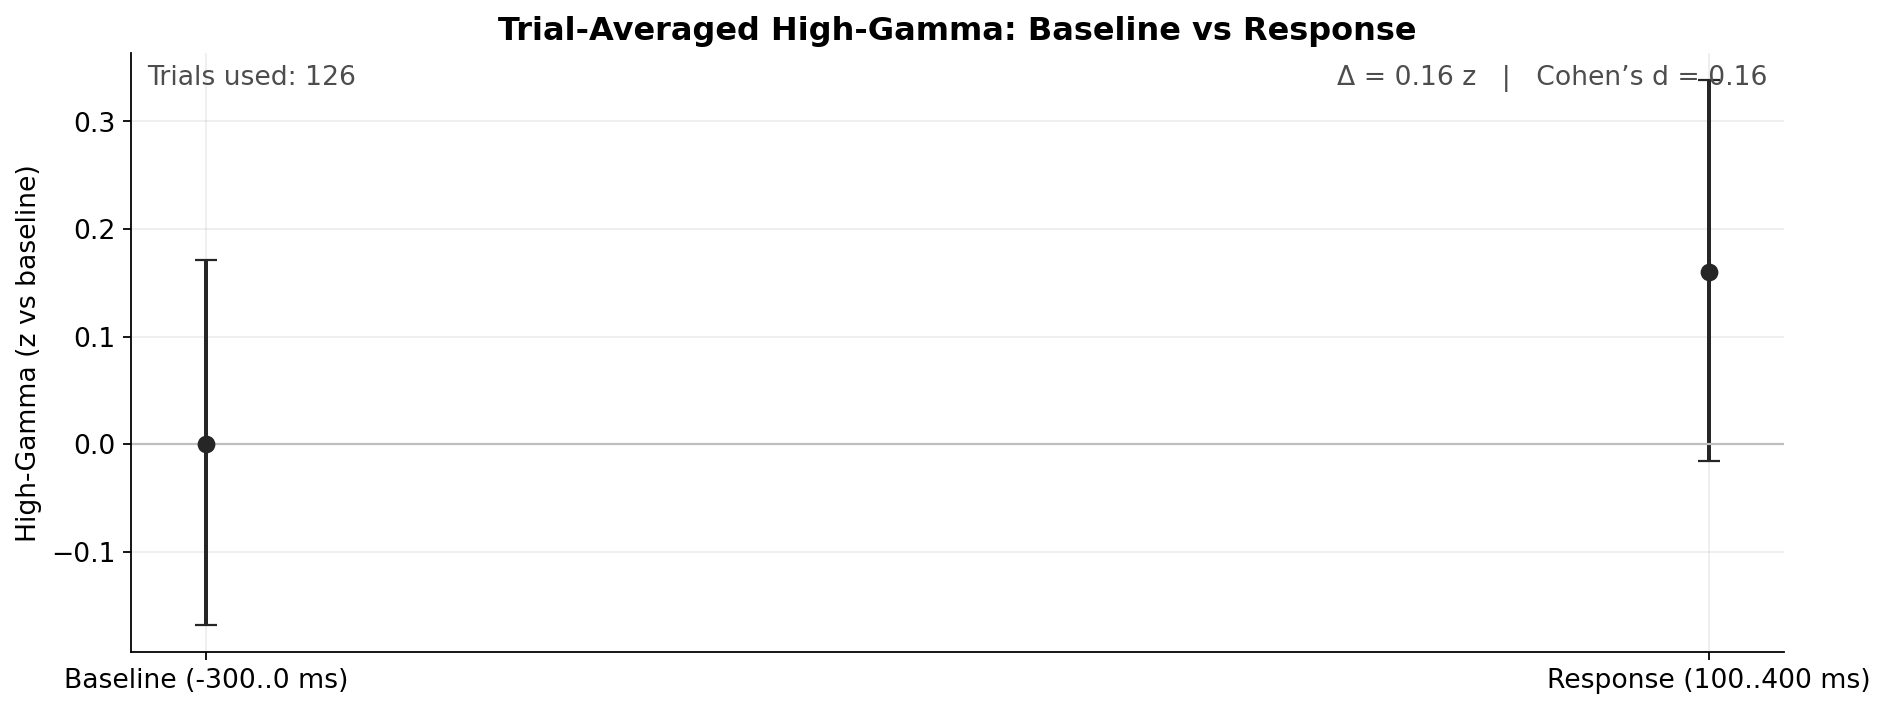

Saved: C:\Users\aryan\iCloudDrive\gtec hackathon\ecog-video\reports\figures\fe_08_baseline_response_clean.png


In [6]:
# ==== Figure 8 (publication style): Baseline vs Response (mean ± 95% CI) ====
import numpy as np
import matplotlib.pyplot as plt

# ----- Windows (ms) -> samples -----
BL_ms = C.BASELINE_MS
RS_ms = C.RESPONSE_MS
ms_to_samp = lambda ms: int(round(ms/1000.0 * FS))
BL = (ms_to_samp(BL_ms[0]), ms_to_samp(BL_ms[1]))   # (-300..0) ms
RS = (ms_to_samp(RS_ms[0]), ms_to_samp(RS_ms[1]))   # (100..400) ms

# ----- Trial starts from video rising edges (in 1200 Hz) -----
edges_30 = detect_edges_hysteresis(video_diode, fs=FPS, min_isi_ms=25.0)
edges_1200 = (edges_30 * (FS / FPS)).astype(int)

# ----- Per-trial baseline & response (mean across channels first for robustness) -----
env_mean_ch = ENV.mean(axis=1)  # global HG envelope (time)
bl_vals, rs_vals = [], []

for s0 in edges_1200:
    bl_a, bl_b = s0 + BL[0], s0 + BL[1]
    rs_a, rs_b = s0 + RS[0], s0 + RS[1]
    if bl_a < 0 or rs_b >= len(env_mean_ch):
        continue
    bl_vals.append(env_mean_ch[bl_a:bl_b].mean())
    rs_vals.append(env_mean_ch[rs_a:rs_b].mean())

bl_vals = np.asarray(bl_vals, float)
rs_vals = np.asarray(rs_vals, float)

# ----- Convert to z vs baseline (so baseline ~ 0) -----
mu, sd = bl_vals.mean(), bl_vals.std(ddof=1) + 1e-12
bl_z = (bl_vals - mu) / sd
rs_z = (rs_vals - mu) / sd

# ----- 95% CI (bootstrap; robust & readable) -----
def ci95_boot(a, n_boot=2000, rng=np.random.default_rng(7)):
    a = np.asarray(a, float)
    idx = rng.integers(0, len(a), size=(n_boot, len(a)))
    boot = a[idx].mean(axis=1)
    return np.quantile(boot, [0.025, 0.975])

def mean_ci(a):
    m = float(np.mean(a))
    lo, hi = ci95_boot(a)
    return m, m - lo, hi - m

m_bl, ebl_lo, ebl_hi = mean_ci(bl_z)
m_rs, ers_lo, ers_hi = mean_ci(rs_z)

# ----- Effect size (Cohen's d) + delta -----
delta = m_rs - m_bl
pooled_sd = np.sqrt(((bl_z.var(ddof=1) + rs_z.var(ddof=1)) / 2.0))
cohens_d = delta / (pooled_sd + 1e-12)

# ----- Plot (neutral aesthetics) -----
plt.rcParams.update({
    "figure.figsize": (12, 4.6),
    "figure.dpi": 160,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "grid.alpha": 0.22,
    "axes.grid": True,
    "font.size": 12,
    "axes.titleweight": "bold",
})

x = np.array([0, 1], float)
means = [m_bl, m_rs]
err_lo = [ebl_lo, ers_lo]
err_hi = [ebl_hi, ers_hi]

fig, ax = plt.subplots()

# Use point + CI (no filled bars) in neutral gray
ax.errorbar(
    x, means,
    yerr=[err_lo, err_hi],
    fmt="o", markersize=7,
    linewidth=1.8, capsize=5,
    color="0.15", ecolor="0.15"
)

# Zero line (since baseline is z-scored)
ax.axhline(0, color="0.75", linewidth=1)

# Labels
ax.set_xticks(x, [f"Baseline ({BL_ms[0]:.0f}..{BL_ms[1]:.0f} ms)",
                  f"Response ({RS_ms[0]:.0f}..{RS_ms[1]:.0f} ms)"])
ax.set_ylabel("High-Gamma (z vs baseline)")
ax.set_title("Trial-Averaged High-Gamma: Baseline vs Response")

# Annotate trials, delta, and effect size
n_trials = len(bl_z)
ax.text(0.01, 0.98, f"Trials used: {n_trials}", ha="left", va="top",
        transform=ax.transAxes, color="0.3")
ax.text(0.99, 0.98, f"Δ = {delta:.2f} z   |   Cohen’s d = {cohens_d:.2f}",
        ha="right", va="top", transform=ax.transAxes, color="0.3")

fig.tight_layout()
out = C.FIG_DIR / "fe_08_baseline_response_clean.png"
fig.savefig(out, dpi=180)
plt.show()
print("Saved:", out)
